# Menu <a class="anchor" id="menu"></a>

* [1. Les systèmes de recommandation](#intro)
* [2. Analyses exploratoires](#eda)
    * [2.1 `articles_metadata.csv`](#articles_metadata)
    * [2.2 `clicks_hour_xxx.csv`](#clicks_hour)

# Préparatifs 

In [1]:
import pickle
import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm  #, uniform

In [2]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, log_scale=False, show_grid=False, x_label=None, y_label="Nombre d'articles"):

    fig = plt.figure(figsize=(15, 4))
    ax = sns.barplot(data=data_)
    if show_values:
        ax.bar_label(ax.containers[0])
    if log_scale:
        ax.set_yscale('log')
    if show_grid:
        plt.grid(visible=True, which='major', axis='y')
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [3]:
def explore_quantitative(data, col_name):
    dt = data[col_name]
    print(f'----- UNIVARIATE ANALYSIS for "{col_name}" -----\n',dt.describe(),'\n', sep='\n')

    fig = plt.figure(figsize=(15, 8))

    ax = plt.subplot(2, 2, 1)
    sns.boxplot(x=dt[dt.notnull()])
    plt.title(f"Boxplot for '{col_name}'")

    ax = plt.subplot(2, 2, 2)
    sns.kdeplot(dt, color='red')
    plt.title(f"Density plot for '{col_name}'")

    ax = plt.subplot(2, 2, 4)
    ax.set_title(f"QQplot for {col_name}")
    qqplot(data[data[col_name].notnull()][col_name], norm, fit=True, line="45", ax=ax)

    ###  Missing
    total_size = data.shape[0]
    total_size_nonull = data[col_name].notnull().sum()
    total_size_null = data[col_name].isnull().sum()
    percent_v = 100/total_size*total_size_null

    ax = plt.subplot(2, 2, 3)
    plt.pie(list([total_size_null, total_size_nonull]), labels=["", ""], autopct=lambda x: f"{x:.2f}%", shadow=False)
    plt.title(f"Distribution between rows with and without '{col_name}' values")
    plt.legend(["MISSING"], loc='lower center', bbox_to_anchor=(0, 0))

    fig.tight_layout()
    plt.show()

    print(f"'{col_name}' is missing {total_size_null} over {total_size} ({percent_v:.2f}%)")

---
---
# 1. Les sytèmes de recommandation <a class="anchor" id="intro"></a> [⇪](#menu)

> Le but des systèmes de recommandation est de chercher des similarités entre utilisateurs ou éléments à recommander (livres, films, articles, vétements...) sur la base d'indicateurs permettant de définir de manière implicite ou explicite le degré de satisfaction lié à ces éléments. Une fois les éléments similaires identifiés, on peut recommander les X premiers ou tirer au hasard dans les X premiers etc.

<img src='medias/recommender_matrix.png' width=700>

> ### Dans les systèmes de recommandation, on a 3 approches généralement admises:
> 1. Collaborative Filtering
> 2. Content-based Filtering
> 3. Hybrid recommenders

<img src='medias/collaborative_vs_content_filtering.png' width=700>

> **Collaborative Filtering**<br>
> Le filtrage collaboratif est un ensemble de méthodes qui se basent uniquement sur *les interactions entre les utilisateurs et les éléments* qui ont été enregistrées, afin de produire de nouvelles recommandations.<br>
> <img src='medias/collaborative_filtering.png' width=700>
>
> 1. **Memory Based**
>    * **User-based or user-user collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **utilisateurs** similaires sur la base des évaluations qu'ils ont donné.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*
>    * **Item-based or item-item collaborative filtering**<br>
>        Dans cette approche, la matrice d'évaluation *(rating matrix)* est utilisée pour trouver des **articles** similaires sur la base des évaluations que leur attribuent les utilisateurs.<br>
>        L'un des algorithmes possible dans ce cas est le *Centered-KNN* *(KNNWithMeans)*<br><br>
> 2. **Model Based**
>    * **Matrix factorization**<br>
>        cette approche qui est la principale solution des model based, peut être considéré comme la décomposition d'une grande matrice en un produit de plus petites matrices. Le nombre de ces facteurs peut aller de un à des centaines, voire des milliers.<br>
>        Le nombre de facteurs latents est l'un des éléments qui doivent être optimisés pendant la formation du modèle. <br>
>        Le nombre de facteurs latents affecte les recommandations d'une manière telle que plus le nombre de facteurs est élevé, plus les recommandations sont personnalisées. Mais un trop grand nombre de facteurs peut conduire à un surajustement du modèle.
>
>        Il existe plusieurs algorithmes pouvant correspondre à cette approche:
>        * SVD / SVD++
>        * PCA / NMF
>        * Autoencoders (Neural Networks)

> **Content-based Filtering**<br>
> L'approche basée sur le contenu utilise des informations disponibles *(en plus des scores)* sur les utilisateurs et/ou les articles. Dans ce cas, on utilise donc les caractéristiques des articles pour recommander d'autres articles similaires à ceux que l'utilisateur aime, mais en s'appuyant également sur les actions précédentes, des commentaires, ou d'autres infos disponibles.<br>
> <img src='medias/content_filtering.png' width=700>

> **Hybrid recommenders**<br>
> Un système de recommandation hybride est un type particulier de système de recommandation qui peut être considéré comme la combinaison entre le *Collaborative Filtering* et le *Content-based Filtering*.



---
---
# 2. Analyses Exploratoires <a class="anchor" id="eda"></a> [⇪](#menu)

Le jeu de données proposé par Globo.com contient de nombreux articles, mais tous ne sont peut être pas pertinents pour notre projet... il nous faut donc explore avant.

## 2.1 `articles_metadata.csv` <a class="anchor" id="articles_metadata"></a> [⇪](#menu)

> articles_metadata.csv - CSV file with metadata information about all (364047) published articles 

In [4]:
data_articles = pd.read_csv('data/news-portal-user-interactions-by-globocom/articles_metadata.csv')
display(data_articles.sample(5), data_articles.shape)

,article_id,category_id,created_at_ts,publisher_id,words_count
349414,349414,442,1418735877000,0,164
163487,163487,285,1512980149000,0,216
67967,67967,136,1461920412000,0,171
340024,340024,438,1447416724000,0,199
337366,337366,437,1513442519000,0,171


(364047, 5)

>#### Ce sont les informations permettant de décrire les articles *(nous n'avons accès ni aux titres ni aux textes des articles)*
> - `article_id` est le code d'identification unique de chaque article publié
> - `category_id` est le code d'identification unique de la catégorie à laquelle apprtient l'article
> - `created_at_ts` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'article à été publié
> - `publisher_id` est le code d'identification unique de l'éditeur de l'article *(j'imagine que c'est prévu pour pouvoir s'ouvrir à d'autres éditeurs si ce n'est pas encore le cas)*
> - `words_count` est nombre de mots présents dans l'article
>
> Ce jeu de données est composé de **364K articles** décrites par **5 variables**

### 2.1.1 Vérifications de base <a class="anchor" id="articles_metadata_uni"></a> [⇪](#menu)

In [5]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


### Ajustons les types de colonnes pour faciliter le travail d'analyse

In [6]:
for col in ['article_id', 'category_id', 'publisher_id']:
    data_articles[col] = data_articles[col].astype('category')

In [7]:
data_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   article_id     364047 non-null  category
 1   category_id    364047 non-null  category
 2   created_at_ts  364047 non-null  int64   
 3   publisher_id   364047 non-null  category
 4   words_count    364047 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 18.8 MB


### Vérifions les valeurs *(min, max, mean etc.)*

In [8]:
pd.set_option('float_format', '{:.0f}'.format)

In [9]:
data_articles.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
created_at_ts,364047,1474070237328,42930380229,1159355675000,1444924843500,1489422449000,1509890951000,1520943150000
words_count,364047,191,60,0,159,186,218,6690


In [10]:
data_articles.describe(exclude='number').T

,count,unique,top,freq
article_id,364047,364047,0,1
category_id,364047,461,281,12817
publisher_id,364047,1,0,364047


In [11]:
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> - ⚠️ `created_at_ts` : les dates vont du **27/09/2006 11:14:35 GMT au 13/03/2018 12:12:30 GMT**, alors que le jeu de données est décrit comme allant du  **01/10/2017 au 16/10/2017**. Donc même si l'on considère que les articles peuvent être plus vieux que les click utilisateurs, il est peu probable qu'un article de 2018 trouve légitimment sa place dans notre jeu de données.
>
> - ⚠️ `words_counts` : la taille des articles varie de **0 à 6690**... Un article de 0 mots n'a aucun sens, et 6690 est très au dessus de la moyenne de 186 mots ou même du 3ème quartile de 218 mots.
>

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `article_id` : chaque article possède bien un ID unique
> - `category_id` : on constate qu'il y a 461 catégories d'articles, mais il n'y a pas de raison de croire que c'est un problème.
> - `publisher_id` : on constate qu'il y a 1 seul éditeur, mais c'est tout à fait attendu (on peut imaginer que seul l'équipe de Globo.com peut publier sur Globo.com)

### Doublons

#### Regardons si il y des articles en double sur la base de la colonnes `article_id`

In [12]:
data_articles.duplicated(subset=['article_id']).sum()

0

### Regardons plus en détails la colonne `created_at_ts`

----- UNIVARIATE ANALYSIS for "created_at_ts" -----

count          364047.00
mean    1474070237328.42
std       42930380228.81
min     1159355675000.00
25%     1444924843500.00
50%     1489422449000.00
75%     1509890951000.00
max     1520943150000.00
Name: created_at_ts, dtype: float64




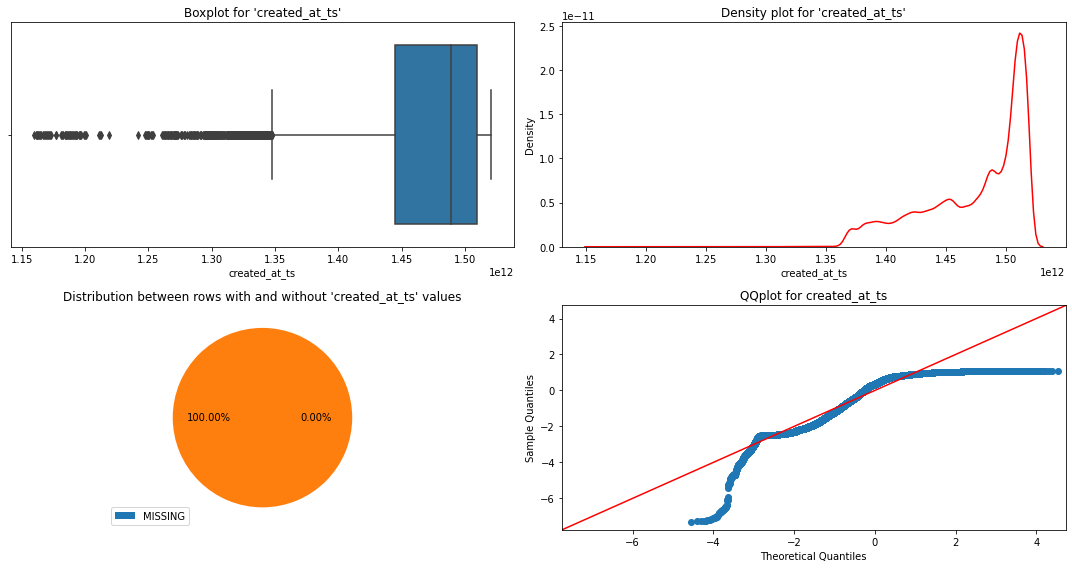

'created_at_ts' is missing 0 over 364047 (0.00%)


In [13]:
explore_quantitative(data_articles, 'created_at_ts')

### Regardons plus en détails la colonne `words_count`

----- UNIVARIATE ANALYSIS for "words_count" -----

count   364047.00
mean       190.90
std         59.50
min          0.00
25%        159.00
50%        186.00
75%        218.00
max       6690.00
Name: words_count, dtype: float64




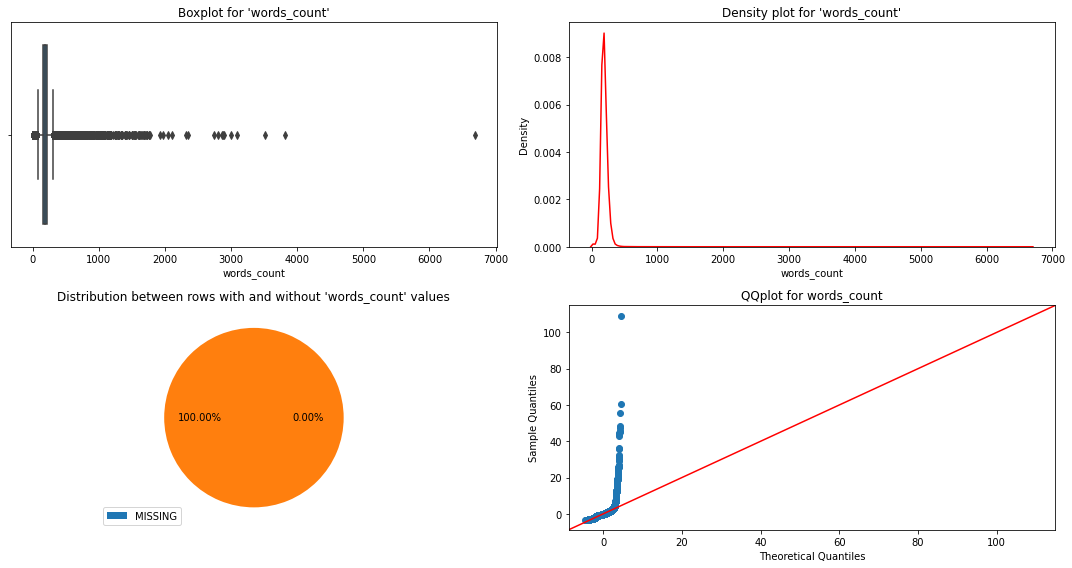

'words_count' is missing 0 over 364047 (0.00%)


In [14]:
explore_quantitative(data_articles, 'words_count')

### 2.1.2 Analyses multivariées <a class="anchor" id="articles_metadata_multi"></a> [⇪](#menu)

### Regardons la repartition des articles dans le temps

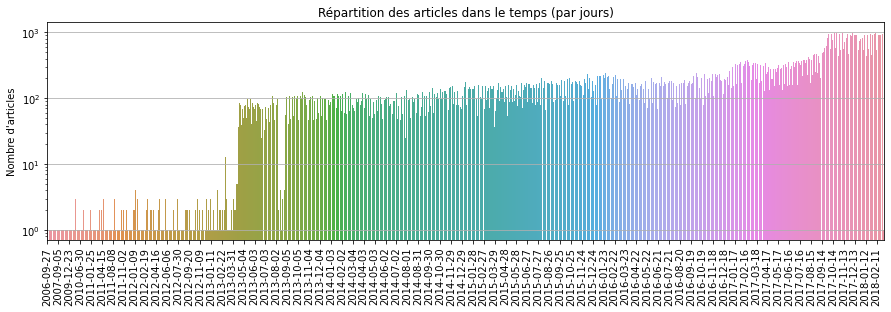

In [15]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(selection, "Répartition des articles dans le temps (par jours)", labels_modulo=30, show_values=False, log_scale=True, show_grid=True, y_label="Nombre d'articles")

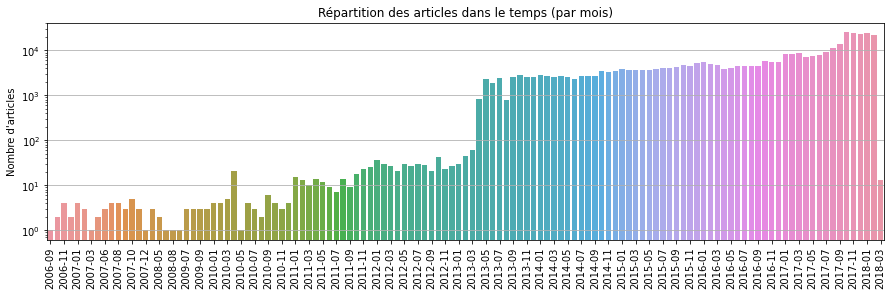

In [16]:
selection = data_articles[['article_id', 'created_at_ts']].copy()
selection['short_date'] = selection['created_at_ts'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(selection, "Répartition des articles dans le temps (par mois)", labels_modulo=2, show_values=False, log_scale=True, show_grid=True, y_label="Nombre d'articles")

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les articles dont les valeurs sont plus récentes que le plus récent des clicks ?<br>(où vont ils être naturellement éliminés losque l'on ne va retenir que les articles aillant reçu un minimum de clicks ?)
> - ❌ Supprimer la colonne `publisher_id` qui ne présente qu'une unique valeur.
> - ❌ Supprimer les articles qui ne sont pas utilisés dans le jeu de données clicks_hour.zip

## 2.2 `clicks_hour_XXX.csv` <a class="anchor" id="clicks_hour"></a> [⇪](#menu)
> clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

### Concatenate all clicks CSV files

clicks.zip - Folder with CSV files (one per hour), containing user sessions interactions in the news portal.

In [17]:
datalist = []
for i in range(0, 385):
    data_tmp = pd.read_csv(f'data/news-portal-user-interactions-by-globocom/clicks/clicks_hour_{i:03}.csv')
    data_tmp['hour'] =  i
    datalist.append(data_tmp)

data_clicks = pd.concat(datalist)
display(data_clicks.head(), data_clicks.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0


(2988181, 13)

>#### Ce sont les informations permettant de décrire les interactions utilisateur sur le site Globo.com
> - `user_id` est le code d'identification unique de chaque utilisateur du site
> - `session_id` est le code d'identification unique de chaque session utilisateur *(chaque session peut avoir plusieurs interactions, donc être présente plusieurs fois)*
> - `session_start` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à commencé sa session sur le site
> - `session_size` est le nombre d'interactions enregistrées dans la session associée
> - `click_article_d` est le code d'identification unique de l'article auquel mène le click
> - `click_timestamp` est le nombre de millisecondes écoulé entre le 01/01/1970 et la moment où l'utilisateur à clické pour visiter l'article associé
> - `click_environment` est ❓
> - `click_deviceGroup` est ❓
> - `click_os` est ❓
> - `click_country` est le code d'identification unique de chaque pays (le 1 semble être le Brézil)
> - `click_region` est le code d'identification unique de chaue région du pays associé
> - `click_referrer` est ❓
> - `hour` est l'identifiant du CSV d'origine contenu dans clicks.zip *(clicks_hour_{HOUR}.csv)*
>
> Ce jeu de données est composé de **299K interactions** décrites par **13 variables**

### 2.1.1 Vérifications de base <a class="anchor" id="clicks_hour_uni"></a> [⇪](#menu)

In [18]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   click_article_id     object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
 12  hour                 int64 
dtypes: int64(1), object(12)
memory usage: 319.2+ MB


### Ajustons les types de colonnes pour faciliter le travail d'analyse

In [19]:
for col in ['user_id', 'session_id', 'click_article_id', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 'click_region', 'click_referrer_type']:
    data_clicks[col] = data_clicks[col].astype('category')
    
for col in ['session_start', 'click_timestamp', 'session_size']:
    data_clicks[col] = data_clicks[col].astype('int64')

In [20]:
data_clicks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988181 entries, 0 to 2568
Data columns (total 13 columns):
 #   Column               Dtype   
---  ------               -----   
 0   user_id              category
 1   session_id           category
 2   session_start        int64   
 3   session_size         int64   
 4   click_article_id     category
 5   click_timestamp      int64   
 6   click_environment    category
 7   click_deviceGroup    category
 8   click_os             category
 9   click_country        category
 10  click_region         category
 11  click_referrer_type  category
 12  hour                 int64   
dtypes: category(9), int64(4)
memory usage: 217.4 MB


### Vérifions les valeurs *(min, max, mean etc.)*

In [21]:
pd.set_option('float_format', '{:.0f}'.format)

In [22]:
data_clicks.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
session_start,2988181,1507472228013,385524460,1506825423000,1507124152000,1507493340000,1507749414000,1508211379000
session_size,2988181,4,4,2,2,3,4,124
click_timestamp,2988181,1507474265606,385850960,1506826800026,1507126852854,1507494930481,1507751004601,1510603454886
hour,2988181,179,107,0,82,185,256,384


In [23]:
data_clicks.describe(exclude='number').T

,count,unique,top,freq
user_id,2988181,322897,5890,1232
session_id,2988181,1048594,1507563657895091,124
click_article_id,2988181,46033,160974,37213
click_environment,2988181,3,4,2904478
click_deviceGroup,2988181,5,1,1823162
click_os,2988181,8,17,1738138
click_country,2988181,11,1,2852406
click_region,2988181,28,25,804985
click_referrer_type,2988181,7,2,1602601


In [24]:
pd.set_option('float_format', '{:.2f}'.format)

>#### Il se pourrait que l'on ait quelques valeurs aberrantes.
> * `session_start`: les dates vont du **01/10/2017 02:37:03 GMT au 17/10/2017 03:36:19 GMT**.
> * `click_timestamp`: les dates vont du **01/10/2017 03:00:00 GMT au 13/11/2017 20:04:14 GMT**.
> <br>⚠️ On a donc une session qui a duré au minimum 27 jours *(17/10 -> 13/11)*.
> * `user_id` : certains utilisateurs semblent avoir un nombre de session très au dessus de la moyenne. Est-ce un problème ❓
> - `session_size` : la taille des sessions varie de **2 à 124**... 124 semble très au dessus du troisième quartile qui est à 4.

>#### En revanches les autres colonnes ne semblent pas présenter de valeurs aberrantes
> - `session_id` : la session la plus fréquente (124) correspond au nombre maximum de session_size (124) et le reste semble cohérent.
> - `click_article_id` : seuls **46033 des 364047 articles sont utilisés**, mais ça ne pose pas de problème.
> - `click_environment` : on a visiblement 3 environnements (web/ios/android ?) pris en compte. Rien d'anormal.
> - `click_deviceGroup`, `click_os`, `click_country`, `click_region`, `click_referrer_type` ont tous des valeurs qui semblent raisonnables même si l'on considère que je ne sais pas toujours ce qu'elles représentent exactement.


### Regardons plus en détails la colonne `session_start`

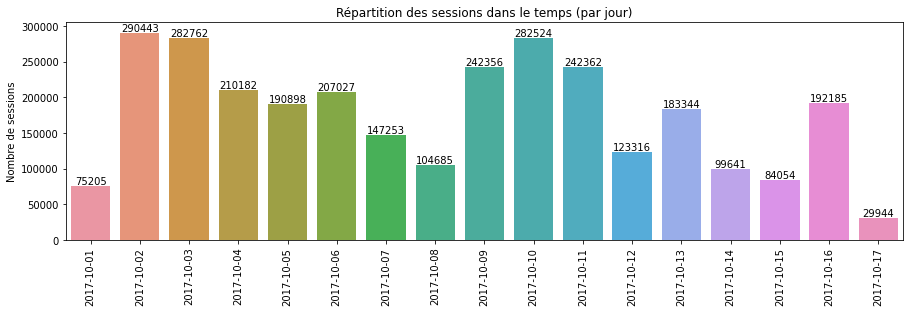

In [25]:
selection = data_clicks[['session_id', 'session_start']].copy()
selection['short_date'] = selection['session_start'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des sessions dans le temps (par jour)", 
     y_label='Nombre de sessions',
    labels_modulo=1, show_values=True,
)

### Regardons plus en détails la colonne `click_timestamp`

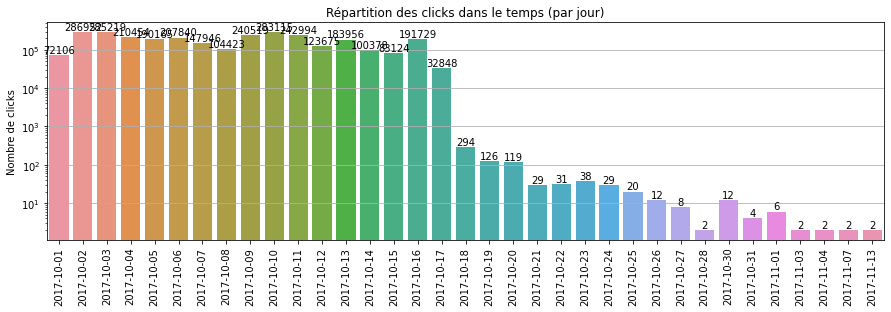

In [26]:
selection = data_clicks[['session_id', 'click_timestamp']].copy()
selection['short_date'] = selection['click_timestamp'].apply(lambda x:datetime.datetime.fromtimestamp(x / 1000).strftime("%Y-%m-%d"))
selection = pd.DataFrame(selection.groupby('short_date').size(), columns=['count']).T

plot_bars(
    selection, 
    "Répartition des clicks dans le temps (par jour)", 
    y_label='Nombre de clicks',
    labels_modulo=1, show_values=True, log_scale=True, show_grid=True, 
)

> #### ⚠️ On note que les dates de clicks s'étendent bien au dela des dates de début de session *(on des clicks presque 1 mois après le dernier début de session enregistré)*

### Regardons le nombre d'articles lus par utilisateurs

num_articles,2,3,4,5,6,7,8,9,10,11,...,501,502,513,529,722,746,783,900,939,1232
num_users,101428.00,22660.00,38432.00,18070.00,20370.00,13358.00,12780.00,9701.00,8807.00,7143.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
num_users_percent,31.41,7.02,11.90,5.60,6.31,4.14,3.96,3.00,2.73,2.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


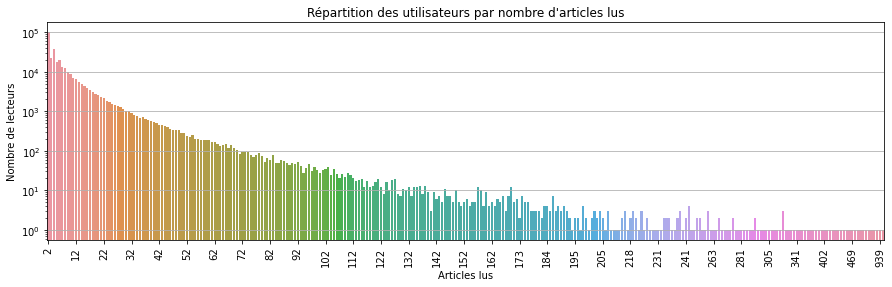

In [27]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus", 
    x_label="Articles lus", y_label="Nombre de lecteurs",
    labels_modulo=10, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

num_articles,2,3,4,5,6,7,8,9,10,11,...,17,18,19,20,21,22,23,24,25,26
num_users,101428.00,22660.00,38432.00,18070.00,20370.00,13358.00,12780.00,9701.00,8807.00,7143.00,...,3458.00,3040.00,2755.00,2557.00,2281.00,2120.00,1864.00,1725.00,1554.00,1487.00
num_users_percent,31.41,7.02,11.90,5.60,6.31,4.14,3.96,3.00,2.73,2.21,...,1.07,0.94,0.85,0.79,0.71,0.66,0.58,0.53,0.48,0.46


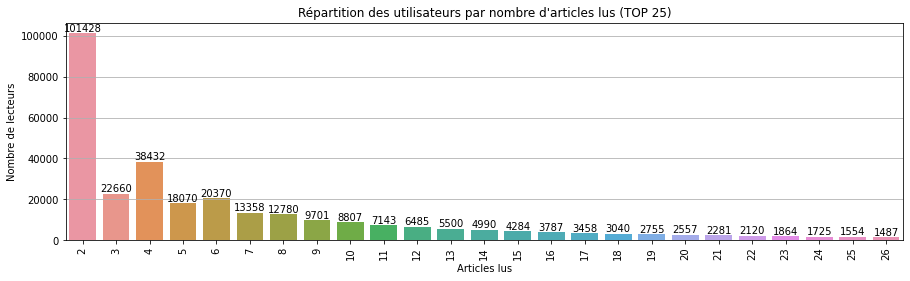

In [28]:
selection = data_clicks[['user_id','click_article_id']].copy()
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])[:25]

selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection
display(selection.T)
selection = selection[['num_users']].T

plot_bars(
    selection, 
    "Répartition des utilisateurs par nombre d'articles lus (TOP 25)", 
    x_label="Articles lus", y_label="Nombre de lecteurs",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [78]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 100
selection = pd.DataFrame(selection.groupby('user_id').size(), columns=['num_articles'])
selection = pd.DataFrame(selection.groupby('num_articles').size(), columns=['num_users'])
selection = selection[ selection.index > min_reads]
selection["num_users_percent"] = 100 / data_clicks['user_id'].nunique() * selection

print(f"{selection['num_users_percent'].sum():.2f}% des utilisateurs ont lus plus de {min_reads} articles")

0.34% des utilisateurs ont lus plus de 100 articles


> * On peut voir que tous les utilisateurs ont lus au moins 2 articles
> * On peut également noter que plus de **31% des utilisateurs n'ont lu que 2 articles**... ils ne sont peut être pas pertinents pour faire de la recommandation.
> * De même en pourcentage cumulé, plus de **50% des utilisateurs ont lus 4 articles ou moins**...
>>
> * En pourcentage cumulé, environ **24% des utilisateurs ont lus 10 articles ou plus**...
> * En pourcentage cumulé, environ **2% des utilisateurs ont lus 50 articles ou plus**...
> * En pourcentage cumulé, environ **0.3% des utilisateurs ont lus 100 articles ou plus**...

### Regardons le nombre de lecteurs par article

total_reads,1,2,3,4,5,6,7,8,9,10,...,19526,20303,21062,21577,21855,23122,23499,23851,28943,37213
num_articles,24811.00,4682.00,2129.00,1315.00,990.00,746.00,621.00,504.00,476.00,384.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
num_articles_percent,53.90,10.17,4.62,2.86,2.15,1.62,1.35,1.09,1.03,0.83,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


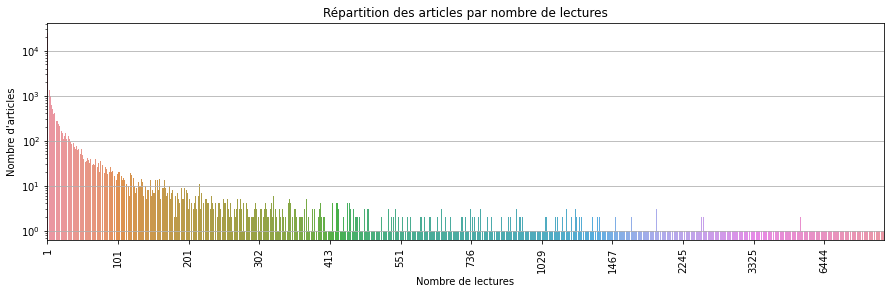

In [31]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures", 
    x_label="Nombre de lectures", y_label="Nombre d'articles",
    labels_modulo=100, show_values=False, log_scale=True, show_grid=True, 
)

Regardons plus en détail les 25 premiers

total_reads,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
num_articles,24811.00,4682.00,2129.00,1315.00,990.00,746.00,621.00,504.00,476.00,384.00,...,247.00,232.00,209.00,193.00,175.00,165.00,149.00,160.00,106.00,126.00
num_articles_percent,53.90,10.17,4.62,2.86,2.15,1.62,1.35,1.09,1.03,0.83,...,0.54,0.50,0.45,0.42,0.38,0.36,0.32,0.35,0.23,0.27


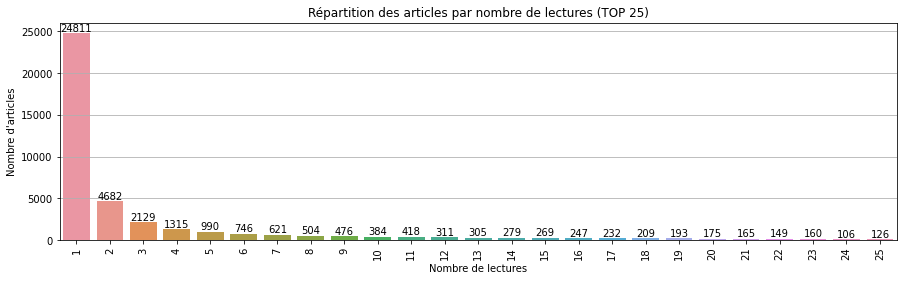

In [30]:
selection = data_clicks[['user_id','click_article_id']].copy()

selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles'])[:25] # ici on a le nombre d'article regroupés par nombre de lectures

selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection
display(selection.T)
selection = selection[['num_articles']].T

plot_bars(
    selection, 
    "Répartition des articles par nombre de lectures (TOP 25)", 
    x_label="Nombre de lectures", y_label="Nombre d'articles",
    labels_modulo=1, show_values=True, log_scale=False, show_grid=True, 
)

In [63]:
selection = data_clicks[['user_id','click_article_id']].copy()

min_reads = 1000
selection = pd.DataFrame(selection.groupby('click_article_id').size(), columns=['total_reads']) # ici on a le nombre de lectures pour chaque article
selection = pd.DataFrame(selection.groupby('total_reads').size(), columns=['num_articles']) # ici on a le nombre d'article regroupés par nombre de lectures
selection = selection[ selection.index > min_reads]
selection["num_articles_percent"] = 100 / data_clicks['click_article_id'].nunique() * selection

print(f"{selection['num_articles_percent'].sum():.2f}% des articles ont été lus plus de {min_reads} fois")

1.16% des articles ont été lus plus de 1000 fois


> * Environ **54% des articles ont été lus une seule fois**...
>>
> * En pourcentage cumulé, environ **75% des articles ont été lus 6 fois ou moins**.
> * En pourcentage cumulé, environ **10% des articles ont été lus plus de 38 fois**.
> * En pourcentage cumulé, environ **5% des articles ont été lus plus de 100 fois**.
> * En pourcentage cumulé, environ **1% des articles ont été lus plus de 1000 fois**.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ❌ Supprimer les sessions dont les utilisateurs qui n'ont lu que peu d'articles (2 ou moins ?)
> - ❌ Supprimer les sessions dont les articles n'ont été lus qu'une seule fois

### ???

(2988181, 13)


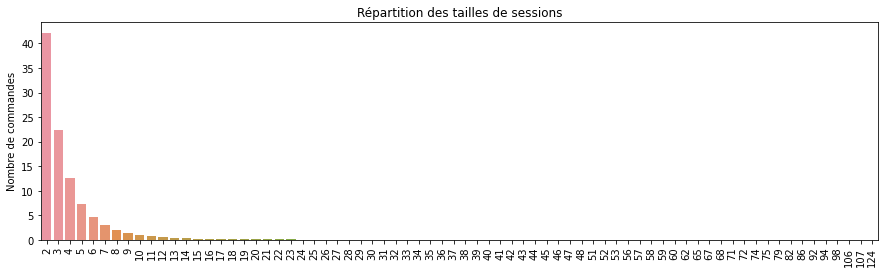

In [85]:
selection = data_clicks.session_size.value_counts()
print(data_clicks.shape)
selection = 100 / data_clicks.shape[0] * selection
selection = pd.DataFrame(selection).sort_index().T
selection
plot_bars(selection, "Répartition des tailles de sessions", labels_modulo=1, show_values=False)

In [100]:
data_clicks[ data_clicks.user_id == 2 ]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2,0
3567,2,1508202613327039,1508202613000,2,30760,1508202879725,4,1,17,1,25,2,382
3568,2,1508202613327039,1508202613000,2,209122,1508202909725,4,1,17,1,25,2,382


* Quelle est le nombre moyen de sessions par utilisateurs ?
* Quelle est le nombre moyen d'interactions par session ?
* Combien d'articles sont 'relus' ?
* 

## Load clicks sample (1 Hour - id=000)

In [35]:
data_clicks_1H = pd.read_csv('data/news-portal-user-interactions-by-globocom/clicks_sample.csv')
display(data_clicks_1H.head(), data_clicks_1H.shape)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


(1883, 12)

In [19]:
data_clicks_1H.describe(include='all')

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883,1883
mean,356,1506827556617196,1506827556295,3,176718,1506829640998,4,2,12,1,19,2
std,206,867962819,867947,3,82324,10649377,0,1,8,2,7,1
min,0,1506825423271737,1506825423000,2,2137,1506826800026,1,1,2,1,1,1
25%,182,1506826925929418,1506826925500,2,108854,1506827517964,4,1,2,1,13,1
50%,353,1506827612114090,1506827612000,3,157541,1506828163470,4,3,17,1,21,1
75%,537,1506828296131274,1506828296000,4,236698,1506828913450,4,3,19,1,25,2
max,706,1506828979881443,1506828979000,24,363291,1506998154157,4,4,20,11,28,7


## Load the Articles' Embedding

articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.

In [20]:
file = open('data/news-portal-user-interactions-by-globocom/articles_embeddings.pickle',"rb")
article_embedding = pickle.load(file)

In [21]:
article_embedding

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [22]:
article_embedding.shape

(364047, 250)

### Select users with more than `min_clicks`

In [23]:
min_clicks_users = 2

In [24]:
count_users_clicks = data_clicks.groupby('user_id')['session_id'].count().sort_values()
count_users_clicks

user_id
322896       2
97261        2
239894       2
239895       2
239898       2
          ... 
15275      746
80350      783
15867      900
73574      939
5890      1232
Name: session_id, Length: 322897, dtype: int64

In [25]:
select_ids = [k for k,v in count_users_clicks.iteritems() if v >= min_clicks_users]
data_clicks[ data_clicks.click_article_id.isin(select_ids) ]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,384
2565,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,384
2566,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,384
2567,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,384


In [26]:
data_clicks.shape

(2988181, 13)

### Select articles with more than `min_clicks`

In [27]:
min_clicks_articles = 5

In [28]:
count_articles_clicks = data_clicks.groupby('click_article_id')['session_id'].count().sort_values()
count_articles_clicks

click_article_id
3             1
120371        1
120365        1
120361        1
120347        1
          ...  
123909    23122
234698    23499
336221    23851
272143    28943
160974    37213
Name: session_id, Length: 46033, dtype: int64

In [29]:
select_ids = [k for k,v in count_articles_clicks.iteritems() if v >= min_clicks_articles]
data_clicks[ data_clicks.click_article_id.isin(select_ids) ]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2,0
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2,0
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2,0
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2,0
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2564,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1,384
2565,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2,384
2566,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2,384
2567,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2,384


In [30]:
data_clicks.shape

(2988181, 13)

In [31]:
data_clicks[ data_clicks.click_article_id == 160974]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,hour
116,1849,1506840642126600,1506840642000,3,160974,1506840758261,4,1,17,11,28,2,4
1483,6534,1506858794306387,1506858794000,4,160974,1506902635141,4,1,17,1,21,1,9
2155,6781,1506859246224642,1506859246000,5,160974,1506948604990,4,1,17,1,19,2,9
3455,9261,1506863737242232,1506863737000,51,160974,1506936567602,4,1,17,1,8,1,10
334,10044,1506865213106063,1506865213000,2,160974,1506865245940,4,1,17,1,13,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3402,121790,1508147696406437,1508147696000,2,160974,1508148458232,4,1,17,1,13,2,367
12198,291291,1508156761121462,1508156761000,2,160974,1508157764367,4,1,17,1,25,5,369
9538,62759,1508178332148613,1508178332000,3,160974,1508178335400,4,1,17,1,13,5,375
2327,286328,1508191074575096,1508191074000,7,160974,1508191839858,4,1,17,1,21,5,379
